# Exploration of Time Series Forecasting Models

## Introduction

The motivation for this project originated over the summer of 2023 as I finished up my internship at Burlington Stores. As this internship greatly developed my personal skills and introduced me to the world of corporate, I found myself heading into the data science industry without any real machine learning knowledge. This project aims to resolve that ignorance.

In this notebook I explore various methods of time series forecasting. Some topics that are covered in this notebook incude:
- Preprocessing data
- Feature creation and feature engineering
- Apply various models and compare their performance

There are many different methods and models for time series forecasting. This notebook highligts a few that I found interseting and concludes relative comparisons. I also want to mention I am no expert in this field and these models could be improved. This project was used as a chance to explore machine learning (ML) models and their performance -- also to become comfortable reading and writing ML code


### 1. Basic Step

In [259]:
#Imports
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Math
import numpy as np
import math
from numpy import random
from scipy import stats
from scipy.stats import norm

#Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

#Warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings('ignore', category=UserWarning)

### 2. Data Loading and Data Exploration

In this section I explore a dataset from Conor Rothwell. This dataset is weather data taken in hourly interval across different stations in Ireland.

In [210]:
#Read in data
file_path = "/Users/MasonHolcombe/Desktop/Personal DS Project/hrly_Irish_weather.csv"
rawdata = pd.read_csv(file_path, low_memory=False)

Let's get an insight into what our data looks like

In [211]:
rawdata.head()

,county,station,latitude,longitude,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
0,Galway,ATHENRY,53.289,-8.786,26-jun-2011 01:00,0.0,15.3,14.5,13.9,15.8,90,1016.0,8,190,NaN,NaN,NaN,NaN
1,Galway,ATHENRY,53.289,-8.786,26-jun-2011 02:00,0.0,14.7,13.7,12.9,14.9,89,1015.8,7,190,NaN,NaN,NaN,NaN
2,Galway,ATHENRY,53.289,-8.786,26-jun-2011 03:00,0.0,14.3,13.4,12.6,14.6,89,1015.5,6,190,NaN,NaN,NaN,NaN
3,Galway,ATHENRY,53.289,-8.786,26-jun-2011 04:00,0.0,14.4,13.6,12.8,14.8,90,1015.3,7,180,NaN,NaN,NaN,NaN
4,Galway,ATHENRY,53.289,-8.786,26-jun-2011 05:00,0.0,14.4,13.5,12.7,14.7,89,1015.1,6,190,NaN,NaN,NaN,NaN


Now let's look at the size of our data

In [212]:
rawdata.shape

(4660423, 18)

To lighten the load on my computer, and also to speed up calculations, I am going to take the first 500k indices. This split and distribution ends up working quite well with some of the models.

In this step I am also going to drop all columns besides the 'temp' column. Throughout this notebook I explore various ways of predicting the temperature from previous temperatures, also predicting the temperature from mathematically made features. Note: You could very well use the other columns of this data set to help predict the temperature.

I am also setting the index of my data to be the date column.

In [213]:
#Drop unnecessary columns and set index
data_split_index = 500000 #ONLY TAKING FIRST 500000 DATA POINTS
data = rawdata \
        .drop(['county', 'station', 'latitude', 'longitude',
               'rain', 'sun', 'wetb', 'dewpt', 'vappr',
               'vis', 'clht', 'clamt', 'rhum', 'msl', 'wdsp', 'wddir'], axis=1)
data = data.set_index('date')
data = data[:data_split_index]


You will notice that the indices of my data are of dtype='object'. This will lead to matplotlib returning an error when using the indices as the x-axis for our plots. 

In [214]:
data.index

Index(['26-jun-2011 01:00', '26-jun-2011 02:00', '26-jun-2011 03:00',
       '26-jun-2011 04:00', '26-jun-2011 05:00', '26-jun-2011 06:00',
       '26-jun-2011 07:00', '26-jun-2011 08:00', '26-jun-2011 09:00',
       '26-jun-2011 10:00',
       ...
       '08-jun-1992 21:00', '08-jun-1992 22:00', '08-jun-1992 23:00',
       '09-jun-1992 00:00', '09-jun-1992 01:00', '09-jun-1992 02:00',
       '09-jun-1992 03:00', '09-jun-1992 04:00', '09-jun-1992 05:00',
       '09-jun-1992 06:00'],
      dtype='object', name='date', length=500000)

To change this, we have to use pd.to_datetime and specify that we want each element to be parsed individually, (format = 'mixed'). In this section I also sort the dates and we see we have dates ranging from Jan 1st 1990 to June 1st 2020.

In [215]:
data.index = pd.to_datetime(data.index, format='mixed')
data = data.sort_index()
data.index

DatetimeIndex(['1990-01-01 00:00:00', '1990-01-01 00:00:00',
               '1990-01-01 01:00:00', '1990-01-01 01:00:00',
               '1990-01-01 02:00:00', '1990-01-01 02:00:00',
               '1990-01-01 03:00:00', '1990-01-01 03:00:00',
               '1990-01-01 04:00:00', '1990-01-01 04:00:00',
               ...
               '2020-05-31 21:00:00', '2020-05-31 22:00:00',
               '2020-05-31 22:00:00', '2020-05-31 22:00:00',
               '2020-05-31 23:00:00', '2020-05-31 23:00:00',
               '2020-05-31 23:00:00', '2020-06-01 00:00:00',
               '2020-06-01 00:00:00', '2020-06-01 00:00:00'],
              dtype='datetime64[ns]', name='date', length=500000, freq=None)

Looking at the first and last few indices, we see we have multiple temperatures at the same hour. The easiest way of handling this is to take the mean temperature at each hour so that each hour has a unique temperature.

In this section I also replace any missing data (encoded as ' ' ) with Na.

In [216]:
data = data.replace(' ', pd.NA) 
data['temp'] = pd.to_numeric(data['temp'])
df = data.groupby(data.index)['temp'].mean()

Looking at our data now, we have processed the data down to have a unique temperature at each hour from Jan 1st 1990 to June 1st 2020.

In [217]:
df

date
1990-01-01 00:00:00     8.400000
1990-01-01 01:00:00     8.300000
1990-01-01 02:00:00     8.650000
1990-01-01 03:00:00     8.400000
1990-01-01 04:00:00     7.650000
                         ...    
2020-05-31 20:00:00    18.200000
2020-05-31 21:00:00    16.666667
2020-05-31 22:00:00    15.100000
2020-05-31 23:00:00    13.966667
2020-06-01 00:00:00    12.833333
Name: temp, Length: 266617, dtype: float64

Let's get the first peak at what our data looks like graphed out

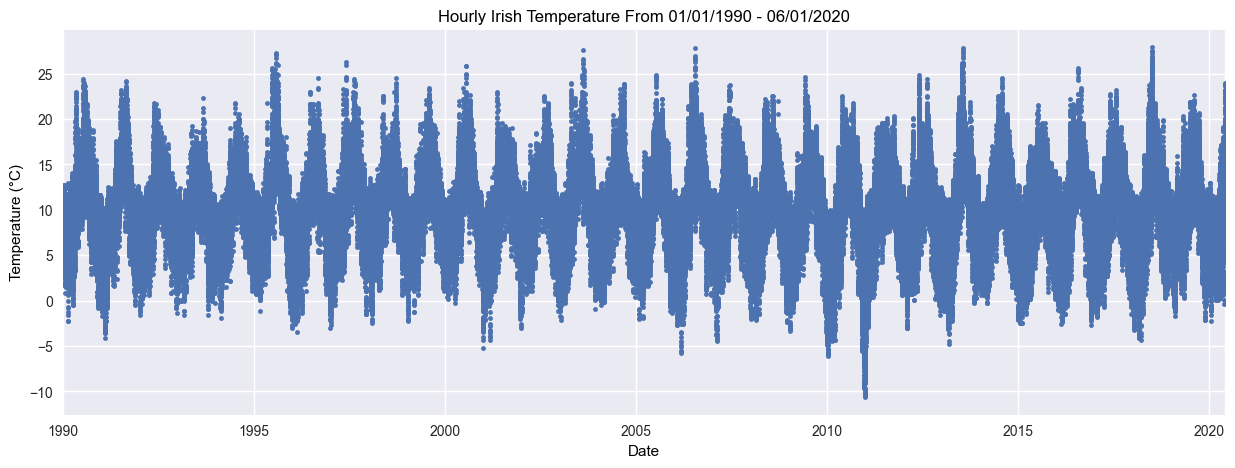

In [218]:
plt.style.use('seaborn-v0_8')
df.plot(style='.', figsize=(15,5))
plt.xlabel('Date', color='black')
plt.ylabel('Temperature (°C)', color='black')
plt.title('Hourly Irish Temperature From 01/01/1990 - 06/01/2020', color='black')
plt.show()

### 3. Prepare Data for training models

Throughout the notebook I use many functions to help me split the data, create features, also to predict and plot the data. These functions are listed here


In [219]:
#Setup
epochs = 20
WINDOW_SIZE = 5
start = 0
end = 500

The functions below convert our df (processed data) into our feature and label set. The first function does so for the 1 dimension GRU and CNN and the second function does so for the multivariate LSTM model. The bottom function actuall splits the feature and label set into train and test sets.

In [220]:
def gru_cnn_converter(df, window_size=WINDOW_SIZE):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

def lstm_converter(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

def gru_cnn_split(X, y):
    split_index = int(len(X)*0.7)
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test

The next function creates the featuers for the calendar associated features for the XGBoost model.

In [221]:
def create_features(df):
    df = df.copy()
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

The final set of functions plot our metric (MAE, MSE, and RMSE) scores during the training process and plot our predictions for the sequential models.

In [222]:
def plot_predicitons(model, X, y, start, end, header='Model'):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  df = df.set_index(indices_for_plotting)
  plt.style.use('seaborn-v0_8')
  plt.figure(figsize = (13,7))
  plt.plot(df['Actuals'][start:end], label='Actual', lw=3)
  plt.plot(df['Predictions'][start:end], label='Predictions', color='red', lw=1.5)
  plt.title('Predictions vs Actuals')
  plt.xlabel('Date')
  plt.ylabel('Temperature (°C)')
  plt.title(f'{header} Temperature Prediciton vs Actuals for Index {start}-{end} in Test Set', c='black')
  plt.legend()
  return

def plot_metrics(modelfit, epochs):
    plt.plot(modelfit.history['mean_absolute_error'], label="MAE")
    plt.plot(modelfit.history['mean_squared_error'], label="MSE")
    plt.plot(modelfit.history['root_mean_squared_error'], label="RMSE")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.xticks(ticks = list(range(epochs)))

With one of the functions above, we now split our df for the 'Sequential' models below. This split into X and y is a crucial step in the ML process. In our case, X is the training data and y is the label data (which is each temperature + WINDOW_SIZE). Notice the first value in y is 6.5 and that corresponds to the last value of the second list in X or X[1][-1]

In [223]:
#Data Split
X, y = gru_cnn_converter(df, WINDOW_SIZE)
print('X =', X)
print('y =', y)

X = [[[ 8.4       ]
  [ 8.3       ]
  [ 8.65      ]
  [ 8.4       ]
  [ 7.65      ]]

 [[ 8.3       ]
  [ 8.65      ]
  [ 8.4       ]
  [ 7.65      ]
  [ 6.5       ]]

 [[ 8.65      ]
  [ 8.4       ]
  [ 7.65      ]
  [ 6.5       ]
  [ 6.15      ]]

 ...

 [[21.06666667]
  [20.5       ]
  [19.36666667]
  [18.2       ]
  [16.66666667]]

 [[20.5       ]
  [19.36666667]
  [18.2       ]
  [16.66666667]
  [15.1       ]]

 [[19.36666667]
  [18.2       ]
  [16.66666667]
  [15.1       ]
  [13.96666667]]]
y = [ 6.5         6.15        6.4        ... 15.1        13.96666667
 12.83333333]


Most of the models below are Sequential models from tensorflow's Keras's models library. However, the XGBoost model is from a different library . Because I am comparing all of the sequential models on the same test/train split, I intend to change the train/test data for the XGBoost model. For this model, I will use the calendar features of the date to predict the temperature. So after my split, I call the create_features function which encodes hour, month, year, etc into the dataframe.

In [224]:
xgboost_df = df

def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

xgb_X_train_split, xgb_X_test_split = split_data(xgboost_df, '2011-04-17 07:00:00') #Same split as GRU, CNN

xgb_X_train_split.index = pd.to_datetime(xgb_X_train_split.index)
train = xgb_X_train_split.sort_index()

xgb_X_test_split.index = pd.to_datetime(xgb_X_test_split.index)
test = xgb_X_test_split.sort_index()

xgb_X_train_features = create_features(train)
xgb_X_test_features = create_features(test)

xgb_X_train = xgb_X_train_features.drop('temp', axis=1)
xgb_X_test = xgb_X_test_features.drop('temp', axis=1)


tempdf = pd.DataFrame(train)
temptestdf = pd.DataFrame(test)

xgb_y_train = tempdf['temp']
xgb_y_test = temptestdf['temp']

You will see here that our train data only has the calendar features and our label data only contains the temperature.

In [225]:
xgb_X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
date,,,,,,,
1990-01-01 00:00:00,0,0,1,1,1990,1,1
1990-01-01 01:00:00,1,0,1,1,1990,1,1
1990-01-01 02:00:00,2,0,1,1,1990,1,1
1990-01-01 03:00:00,3,0,1,1,1990,1,1
1990-01-01 04:00:00,4,0,1,1,1990,1,1
...,...,...,...,...,...,...,...
2011-04-17 03:00:00,3,6,2,4,2011,107,17
2011-04-17 04:00:00,4,6,2,4,2011,107,17
2011-04-17 05:00:00,5,6,2,4,2011,107,17


In [226]:
xgb_y_train

date
1990-01-01 00:00:00    8.40
1990-01-01 01:00:00    8.30
1990-01-01 02:00:00    8.65
1990-01-01 03:00:00    8.40
1990-01-01 04:00:00    7.65
                       ... 
2011-04-17 03:00:00    7.80
2011-04-17 04:00:00    7.35
2011-04-17 05:00:00    7.40
2011-04-17 06:00:00    7.50
2011-04-17 07:00:00    8.25
Name: temp, Length: 186632, dtype: float64

Thoughout this notebook I will be exploring 3 of the models in Keras' Sequential library (GRU, CNN, and LSTM). For the first two I will use temperature to predict temperature, but for the LSTM model, I will use temperature and sine/cosine of the day and the sine/cosine of the year. Because of the periodicity in the dataset, including the sine/cosine of the day and year will incorporate the temperature data with a steady moving feature. This is an example of feature engineering and this concept can be extended to great lengths.

We start by getting the seconds column onto the dataset

In [227]:
lstm_df = pd.DataFrame(df)
lstm_df['Seconds'] = lstm_df.index.map(pd.Timestamp.timestamp)
lstm_df['Seconds'] = lstm_df['Seconds'] - lstm_df['Seconds'][0] #START AT 0 SECONDS

Now, let's incorporate the sine/cosine into the dataset.

In [228]:
day = 60*60*24
year = 365.2425*day

lstm_df['Day sin'] = np.sin(lstm_df['Seconds'] * (2*np.pi / day))
lstm_df['Day cos'] = np.cos(lstm_df['Seconds'] * (2*np.pi / day))
lstm_df['Year sin'] = np.sin(lstm_df['Seconds'] * (2*np.pi / year))
lstm_df['Year cos'] = np.cos(lstm_df['Seconds'] * (2*np.pi / year))

Now we can drop the seconds column from the dataset so that the only features going into the model are:
- temperature
- sine/cosine of the day
- sin/cosine of the year

Because this data has 4 more columns than the GRU and CNN models, we have to use lstm_converter to create the features and labels for the model.

In [229]:
temp_df = lstm_df.drop('Seconds', axis=1)
lstm_X, lstm_y = lstm_converter(temp_df)

temp_df

,temp,Day sin,Day cos,Year sin,Year cos
date,,,,,
1990-01-01 00:00:00,8.400000,0.000000e+00,1.000000,0.000000,1.000000
1990-01-01 01:00:00,8.300000,2.588190e-01,0.965926,0.000717,1.000000
1990-01-01 02:00:00,8.650000,5.000000e-01,0.866025,0.001434,0.999999
1990-01-01 03:00:00,8.400000,7.071068e-01,0.707107,0.002150,0.999998
1990-01-01 04:00:00,7.650000,8.660254e-01,0.500000,0.002867,0.999996
...,...,...,...,...,...
2020-05-31 20:00:00,18.200000,-8.660254e-01,0.500000,0.509298,-0.860590
2020-05-31 21:00:00,16.666667,-7.071068e-01,0.707107,0.508681,-0.860955
2020-05-31 22:00:00,15.100000,-5.000000e-01,0.866025,0.508063,-0.861320


To achieve our train/test split, I use the same formula for a split index as the GRU & CNN models.

In [230]:
split_index = int(len(lstm_X)*0.7)
lstm_X_train, lstm_y_train = lstm_X[:split_index], lstm_y[:split_index]
lstm_X_test, lstm_y_test = lstm_X[split_index:], lstm_y[split_index:]

Because temperature is not on the same scale has sine/cosine, we have to normalize the data before going into the LSTM model. We do this by computing the lstm_X_train mean and standard deviation and then subtracting the mean and dividing by the standard deviation to each value.

In [231]:
lstm_training_mean = np.mean(lstm_X_train[:, :, 0])
lstm_training_std = np.std(lstm_X_train[:, :, 0])

def preprocess(X):
    X= ((X - lstm_training_mean) / lstm_training_std)

preprocess(lstm_X_train)
preprocess(lstm_y_test)

## Models

### 4. Moving Average

One of the most basic time series forecasting methods is a simple moving average. I wanted to include this method for its simplicity and also to show that if you decrease the moving average window (ma_window), the rolling average gets closer and closer to the real data (by defintion).

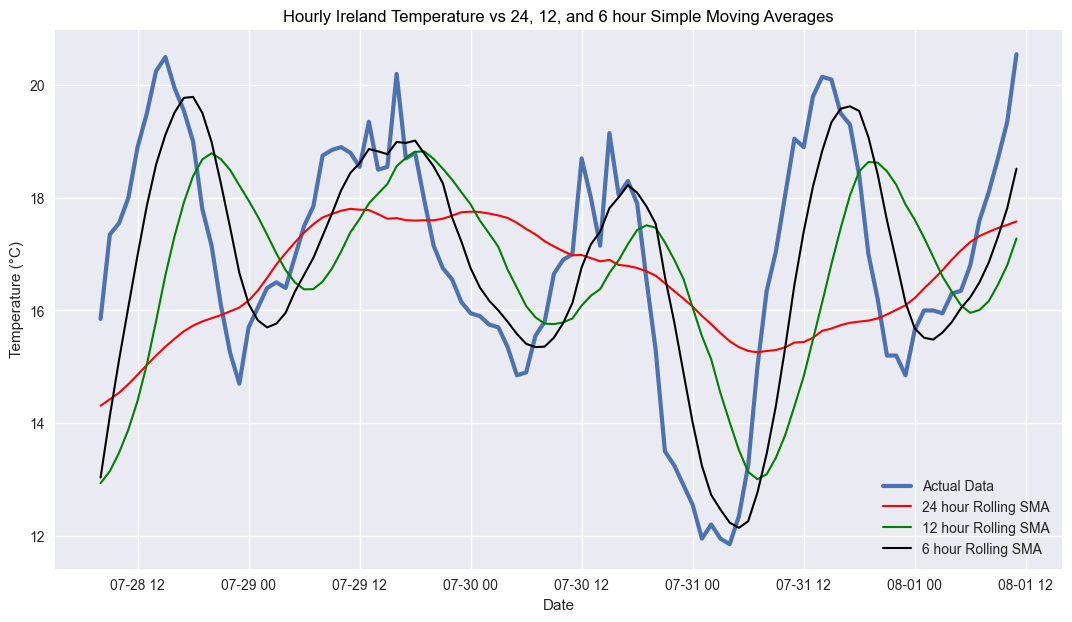

In [232]:
#Simple Moving Average

start = 5000
end = 5100
ma_window = 24

sma = df.rolling(window=ma_window).mean()
sma1 = df.rolling(window=ma_window-12).mean()
sma2 = df.rolling(window=ma_window-18).mean()


plt.style.use('seaborn-v0_8')
plt.figure(figsize = (13,7))
plt.plot(df[start:end],label='Actual Data',linewidth=3)
plt.plot(sma[start:end],label=f'{ma_window} hour Rolling SMA',linewidth=1.5, color='red')
plt.plot(sma1[start:end],label=f'{ma_window-12} hour Rolling SMA',linewidth=1.5, color='green')
plt.plot(sma2[start:end],label=f'{ma_window-18} hour Rolling SMA',linewidth=1.5, color='black')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Hourly Ireland Temperature vs {ma_window}, {ma_window-12}, and {ma_window-18} hour Simple Moving Averages', c='black')
plt.legend()
plt.show()

### 2. XGBoost (Extreme Gradient Boost)

The first model that I wanted to try was the Extreme Gradient Boosting model or XGBoost. This model has become popular over the last few years and a lot of people believe it to be one of the better ML models.

To start, we need to create the model, here we use a XGBRegressor since we are using regression to find the next values, and fit the data with xgb_X_train and xgb_y_train.

In [233]:
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.05, objective='reg:absoluteerror')
xgbfit = reg.fit(xgb_X_train, xgb_y_train,
        eval_set=[(xgb_X_test, xgb_y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBoost also provides a nice function called plot_importance to see what features in your dataset impacted the Regressor model most. Let's take a look at what features were most involved.

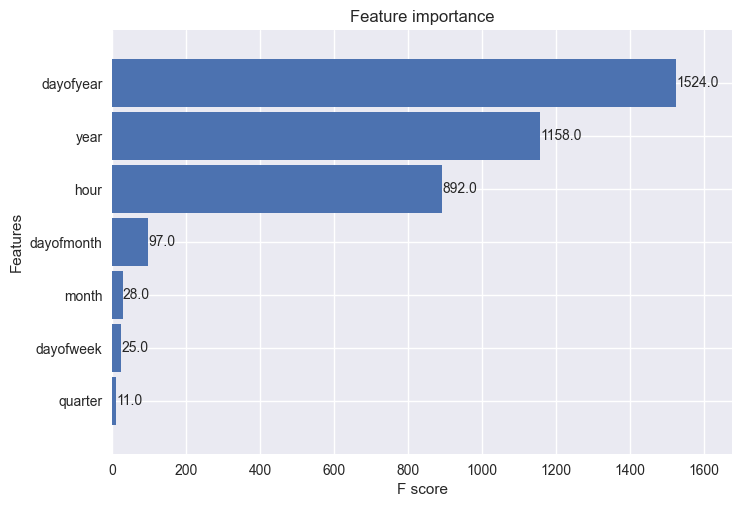

In [234]:
xgb.plot_importance(reg, height=0.9)
plt.show()

Now that we have a fitted model, we can use that model to predict on our xgb_X_test set

In [235]:
xgbpreds = reg.predict(xgb_X_test)
xgbpreds

array([ 7.495297,  8.466829,  9.712773, ..., 11.873252, 11.873252,
       10.900991], dtype=float32)

To see the metrics on how our XGBoost model did, we can use the metrics library from TensorFlow's Keras. Throughout this notebook, I will be analyzing 3 key metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)

In [236]:
xgbmae = mean_absolute_error(xgb_y_test, xgbpreds)
xgbmse = tf.keras.backend.get_value(mean_squared_error(xgb_y_test, xgbpreds))
xgbrmse = math.sqrt(mean_squared_error(xgb_y_test, xgbpreds))

print("MAE of XGBoost Model: ", xgbmae)
print("MSE of XGBoost Model: ", xgbmse)
print("RMSE of XGBoost Model: ", xgbrmse)

MAE of XGBoost Model:  2.1344646276410923
MSE of XGBoost Model:  7.533481
RMSE of XGBoost Model:  2.7447187690295762


To get a better understanding of the predictions, let's graph the xgbpreds and xgb_y_test to see graphically how our model did.

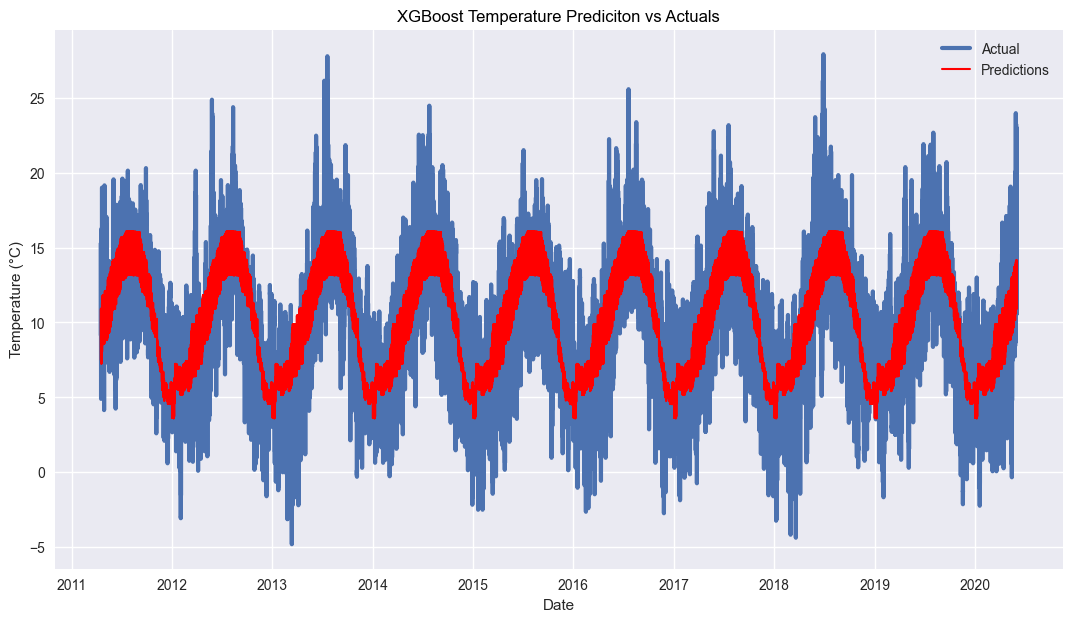

In [237]:
xgb_indices_for_plotting = []
for i in range(len(xgb_y_test)):
    xgb_indices_for_plotting.append(df.index[-len(xgb_y_test) + i])
xgb_indices_for_plotting = pd.Series(xgb_indices_for_plotting)

temporarydf = pd.DataFrame(data={'Predictions':xgbpreds, 'Actuals':xgb_y_test})
temporarydf = temporarydf.set_index(xgb_indices_for_plotting)
plt.style.use('seaborn-v0_8')
plt.figure(figsize = (13,7))
plt.plot(temporarydf['Actuals'], label='Actual', lw=3)
plt.plot(temporarydf['Predictions'], label='Predictions', color='red', lw=1.5)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'XGBoost Temperature Prediciton vs Actuals', c='black')
plt.legend()
plt.show()

Let's look at a smaller section of our predicitons and test set to see what behavior our model picked up on.

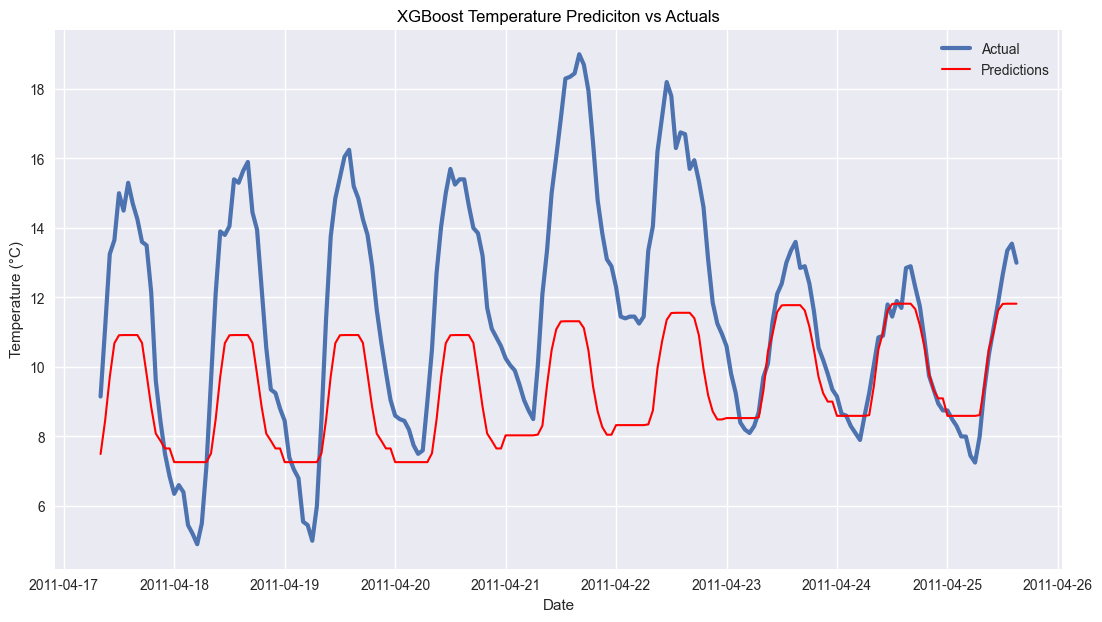

In [238]:
plt.figure(figsize = (13,7))
plt.plot(temporarydf['Actuals'][0:200], label='Actual', lw=3)
plt.plot(temporarydf['Predictions'][0:200], label='Predictions', color='red', lw=1.5)
plt.title('Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'XGBoost Temperature Prediciton vs Actuals', c='black')
plt.legend()
plt.show()

It seems that a daily periodic trend was found in our dataset which aligned with the actual temperature. However, the XGBoost model failed to accurately predict the amplitude for these fluctuations. 

### 5. GRU (Gated Recurrent Unit)

The next set of models are all going to be from TensorFlow's Keras' Sequential library. 

The first model that I am going to look at is the Gated Recurrent Unit (GRU). I got the motivation for these particular models from this [YouTube video](https://www.youtube.com/watch?v=kGdbPnMCdOg) by Greg Hogg. I highly recommend Greg's YouTube channel, some very high quality work!

I start by getting my train/test split for both my features and my labels. I do this by calling the gru_cnn_split() function with my original X (features) and y (labels)


In [239]:
gru_X_train, gru_y_train, gru_X_test, gru_y_test = gru_cnn_split(X, y)

Next, I create the actual model. I do this by creating the Sequential object and add various layers to deepen the model. The GRU model comes in the 2nd layer, where I chose this particular GRU model to have 64 layers. I then also create an dense 8 layer with the rectified linear activation function. The last layer is then the output layer which should be linear to give the prediciton.

In [240]:
grumodel = Sequential(name='GRU_Model')
grumodel.add(InputLayer((WINDOW_SIZE, 1)))
grumodel.add(GRU(64, name='GRU'))
grumodel.add(Dense(8, 'relu', name='ReLU'))
grumodel.add(Dense(1, 'linear', name='Linear'))

Next, we need to compile the model from TensorFlow. I do this by calling the .compile() function and choose loss, optimizer, and metric parameters. In this I also decide the learning rate which greatly affects how the model learns. I also fit the model with the gru_X_train data and the gru_y_train data. The epochs in this scenario are referring to the amount of iterations you want the model to run through the data set.

Here we set epochs = 20, so we can see the iterations through the data set in the code output

In [241]:
grumodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[tf.keras.metrics.MeanAbsoluteError(), \
                                                                                       MeanSquaredError(), \
                                                                                       RootMeanSquaredError()])

grufit = grumodel.fit(gru_X_train, gru_y_train, epochs=epochs)

Epoch 1/20


5833/5833 [==============================] - 28s 4ms/step - loss: 0.6076 - mean_absolute_error: 0.5328 - mean_squared_error: 0.6076 - root_mean_squared_error: 0.7795
Epoch 2/20
5833/5833 [==============================] - 24s 4ms/step - loss: 0.4798 - mean_absolute_error: 0.5019 - mean_squared_error: 0.4798 - root_mean_squared_error: 0.6927
Epoch 3/20
5833/5833 [==============================] - 24s 4ms/step - loss: 0.4674 - mean_absolute_error: 0.4935 - mean_squared_error: 0.4675 - root_mean_squared_error: 0.6837
Epoch 4/20
5833/5833 [==============================] - 25s 4ms/step - loss: 0.4649 - mean_absolute_error: 0.4923 - mean_squared_error: 0.4649 - root_mean_squared_error: 0.6818
Epoch 5/20
5833/5833 [==============================] - 26s 4ms/step - loss: 0.4580 - mean_absolute_error: 0.4875 - mean_squared_error: 0.4581 - root_mean_squared_error: 0.6767
Epoch 6/20
5833/5833 [==============================] - 21s 4ms/step - loss: 0.4557 - mean_absolute_error: 0.4863 - mean_squar

Now that we have fitted our model, we can see a summary of our model and we can call the plot_metrics() function to see the MAE, MSE, and RMSE curves over all the epochs.

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 64)                12864     
                                                                 
 ReLU (Dense)                (None, 8)                 520       
                                                                 
 Linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


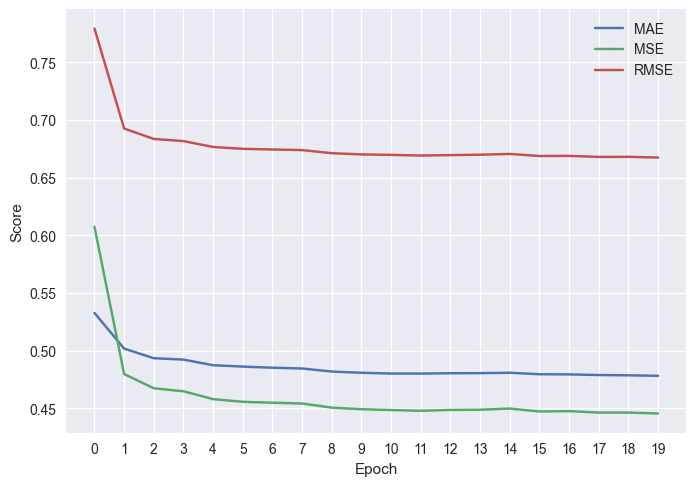

In [242]:
grumodel.summary()
plot_metrics(grufit, epochs)

From the model summary, I can see that the GRU model with this many layers has 13393 parameters, that's quite a lot! However, this model performed a lot better than the XGBoost model and the metric graph can show it. With a MAE of just under 0.5, this model outperformed the XGBoost model by 1.6 °C.

Now let's look at how the GRU model performed graphically against the actual data. First let's see how it compares against the full data set.

2500/2500 [==============================] - 4s 1ms/step


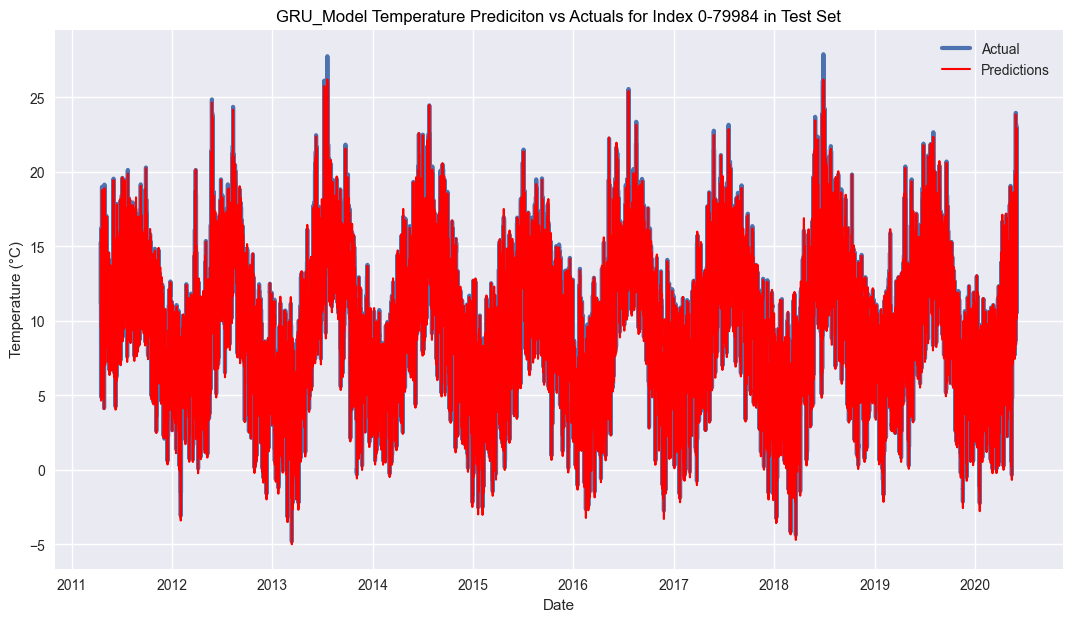

In [243]:
start = 0 # Used for plotting
end = len(gru_y_test) # Used for plotting

indices_for_plotting = []
for i in range(len(gru_y_test)):
    indices_for_plotting.append(df.index[-len(gru_y_test) + i])
indices_for_plotting = pd.Series(indices_for_plotting)



plot_predicitons(grumodel, gru_X_test, gru_y_test, header=grumodel.name, start=start, end=end)

Now let's see how the GRU model predicted against a random 240 hour (10 days) set.

   1/2500 [..............................] - ETA: 1:04

2500/2500 [==============================] - 4s 1ms/step


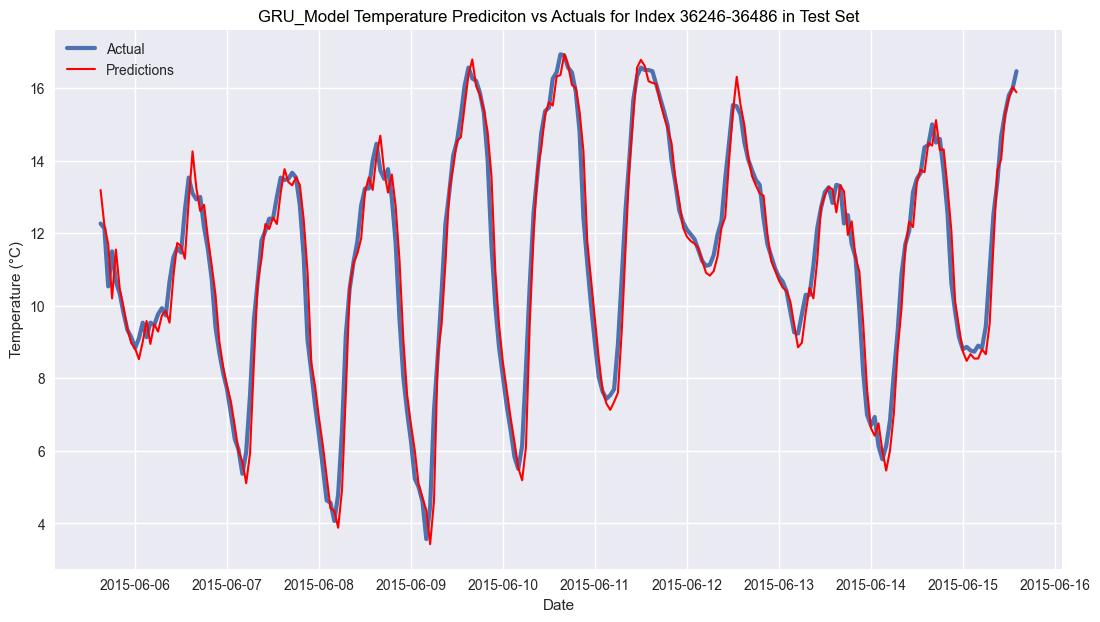

In [244]:
randindex = random.randint(0, len(gru_y_test)-240)
plot_predicitons(grumodel, \
                 gru_X_test, \
                 gru_y_test, \
                 header = grumodel.name, \
                 start = randindex, \
                 end = randindex + 240)

I can see that the GRU model performed very well against the actual data set! A noticeable characteristic about the GRU model is that at the local minimum, the predicitons seem to over predict the temperature value. However, when the data seems to be raising or falling, the GRU model follows it well. 

### 6. 1 Dimensional Convolutional Neural Network

The next model that I wanted to explore is the 1 dimensional convolutional neural network (CNN). This model was particularly interesting because of the importance of 2 dimensional CNNs in image processing. I was eager to explore the 1 dimsional analog and see how we can use it in the context of time series.

This process is very similar to the GRU model, in fact it is almost identical except for a few syntax changes to get the same outputs.

I first get the same train/test split as the GRU model but assign them for the CNN model.

In [245]:
cnn_X_train, cnn_y_train, cnn_X_test, cnn_y_test = gru_cnn_split(X, y)

Next, we create the Sequential object and add the Conv1D layer with a kernel_size of 2. We then add a flatten layer to flatten the data into a single dimensional array. Then, similar to the GRU model, I add 2 Dense layers two produce a single temperature output

In [246]:
cnnmodel = Sequential(name="CNN")
cnnmodel.add(InputLayer((WINDOW_SIZE, 1)))
cnnmodel.add(Conv1D(64, kernel_size=2, name='1D_CNN'))
cnnmodel.add(Flatten(name='Flatten'))
cnnmodel.add(Dense(8, 'relu', name='ReLU'))
cnnmodel.add(Dense(1, 'linear', name='Linear'))

If you haven't got the idea already, we are going to compile and fit the data to the Conv1D model. Here I use all the same loss, optimizer, and metric parameters as the GRU model.

Here I also use 3 epochs.

In [247]:
cnnmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[tf.keras.metrics.MeanAbsoluteError(), \
                                                                                       MeanSquaredError(), \
                                                                                       RootMeanSquaredError()])

cnnfit = cnnmodel.fit(cnn_X_train, cnn_y_train, epochs=epochs)

Epoch 1/20


5833/5833 [==============================] - 8s 1ms/step - loss: 0.5678 - mean_absolute_error: 0.5336 - mean_squared_error: 0.5677 - root_mean_squared_error: 0.7535
Epoch 2/20
5833/5833 [==============================] - 8s 1ms/step - loss: 0.6889 - mean_absolute_error: 0.5343 - mean_squared_error: 0.6890 - root_mean_squared_error: 0.8300
Epoch 3/20
5833/5833 [==============================] - 7s 1ms/step - loss: 0.5095 - mean_absolute_error: 0.5144 - mean_squared_error: 0.5094 - root_mean_squared_error: 0.7138
Epoch 4/20
5833/5833 [==============================] - 7s 1ms/step - loss: 0.4873 - mean_absolute_error: 0.5038 - mean_squared_error: 0.4873 - root_mean_squared_error: 0.6981
Epoch 5/20
5833/5833 [==============================] - 8s 1ms/step - loss: 0.5339 - mean_absolute_error: 0.5165 - mean_squared_error: 0.5338 - root_mean_squared_error: 0.7307
Epoch 6/20
5833/5833 [==============================] - 8s 1ms/step - loss: 0.4813 - mean_absolute_error: 0.5004 - mean_squared_err

Now I can see a summary of the model and I can also use the plot_metrics function to see how the model's metrics changed over time.

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1D_CNN (Conv1D)             (None, 4, 64)             192       
                                                                 
 Flatten (Flatten)           (None, 256)               0         
                                                                 
 ReLU (Dense)                (None, 8)                 2056      
                                                                 
 Linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


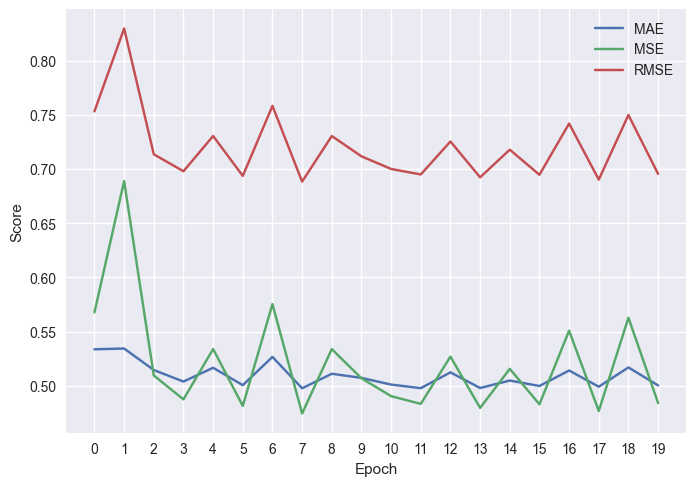

In [248]:
cnnmodel.summary()
plot_metrics(cnnfit, epochs)

I can see that the MAE, MSE, RMSE curves look very similar to the GRU metric curves. All of the CNN metrics were betwewen 0.03 of the GRU metrics but the **key** difference is that the CNN model has a total of 2257 parameters. So, the GRU has 11,136 more parameters then the CNN model and yet they both perform at a similar level.

Because the CNN model performed so similarly to the GRU model, the full graph of the test set will look identically like the GRU graph. Although, I can look at how the CNN model performed on a random set of 240 hours and see on the trends it picked up on.

2500/2500 [==============================] - 2s 782us/step


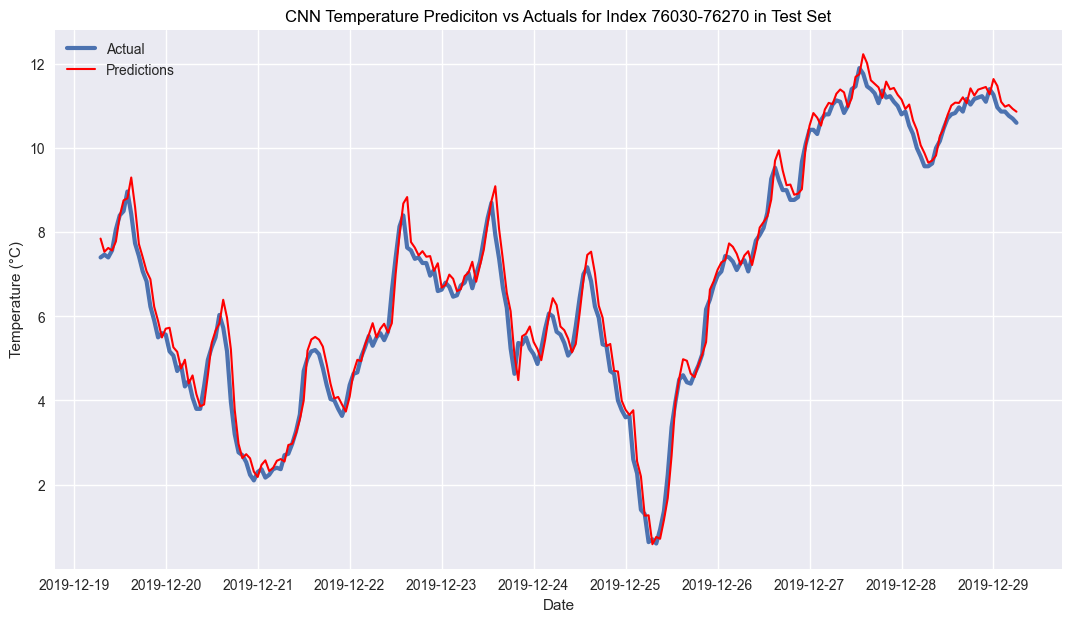

In [249]:
randindex = random.randint(0, len(cnn_y_test)-240)
plot_predicitons(cnnmodel, \
                 cnn_X_test, \
                 cnn_y_test, \
                 header = cnnmodel.name, \
                 start = randindex, \
                 end = randindex + 240)

The CNN model performed a lot like the GRU model, so a lot has already been said. The CNN model also over predicted the local minimum and generally was always greater than the actual temperature value.

### 8. Multivariate LSTM (Long Term Short Memory)

The last model that I am going to explore is a Multivariate Long Term Short Memory (LSTM) model. In the cells above I have preprocessed and normalized the data for this model. 

You will notice that this model also looks very similar to the above GRU and CNN models but the input layer has 5 features. Similar to the other Sequential models, I am going to use two Dense layers at the end to produce a single temperature output.

In [250]:
lstmmodel = Sequential(name='LSTM')
lstmmodel.add(InputLayer((6, 5)))
lstmmodel.add(LSTM(64, name='LSTM'))
lstmmodel.add(Dense(8, 'relu', name='ReLU'))
lstmmodel.add(Dense(1, 'linear', name='Linear'))

Now, similar to above, we will compile the model with the recognizeable loss, optimizer, and metric parameters. Because we preproessed the data above, we have to reconvert the train/test X and y split values to type float32 to fit the model.

In [251]:
lstmmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[tf.keras.metrics.MeanAbsoluteError(), \
                                                                                       MeanSquaredError(), \
                                                                                       RootMeanSquaredError()])

lstm_X_train = np.asarray(lstm_X_train).astype('float32')
lstm_y_train = np.asarray(lstm_y_train).astype('float32')
lstm_X_test = np.asarray(lstm_X_test).astype('float32')
lstm_y_test = np.asarray(lstm_y_test).astype('float32')


lstmfit = lstmmodel.fit(lstm_X_test, lstm_y_test, epochs=epochs)

Epoch 1/20
2500/2500 [==============================] - 10s 3ms/step - loss: 0.4768 - mean_absolute_error: 0.4003 - mean_squared_error: 0.4767 - root_mean_squared_error: 0.6905
Epoch 2/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2016 - mean_absolute_error: 0.3381 - mean_squared_error: 0.2016 - root_mean_squared_error: 0.4490
Epoch 3/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2006 - mean_absolute_error: 0.3374 - mean_squared_error: 0.2006 - root_mean_squared_error: 0.4479
Epoch 4/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1956 - mean_absolute_error: 0.3330 - mean_squared_error: 0.1956 - root_mean_squared_error: 0.4423
Epoch 5/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1865 - mean_absolute_error: 0.3240 - mean_squared_error: 0.1865 - root_mean_squared_error: 0.4319
Epoch 6/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1856 - mean_absolute_error: 0.3239 - mean

I can now use .summary() and the plot_metrics() function to see the the model's layers and the amount of parameters. I can also see how the MAE, MSE, and RMSE metrics values across all epochs 

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 64)                17920     
                                                                 
 ReLU (Dense)                (None, 8)                 520       
                                                                 
 Linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


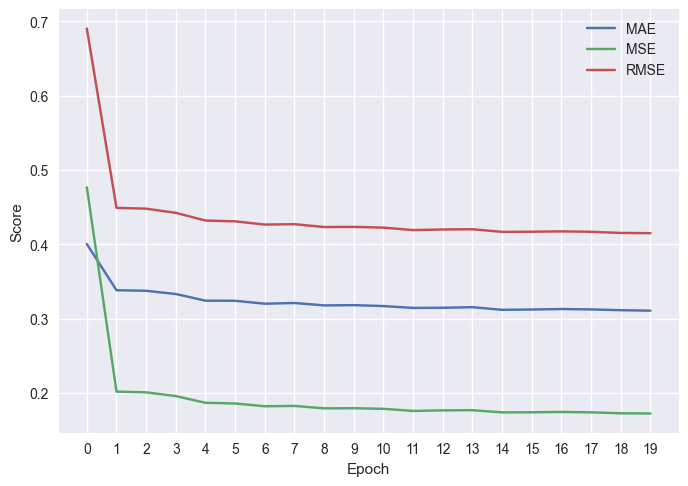

In [252]:
lstmmodel.summary()
plot_metrics(lstmfit, epochs)

Because this data was training with multiple features, let's look at how the predicitons compared to the actual data set graphically.

2500/2500 [==============================] - 4s 1ms/step


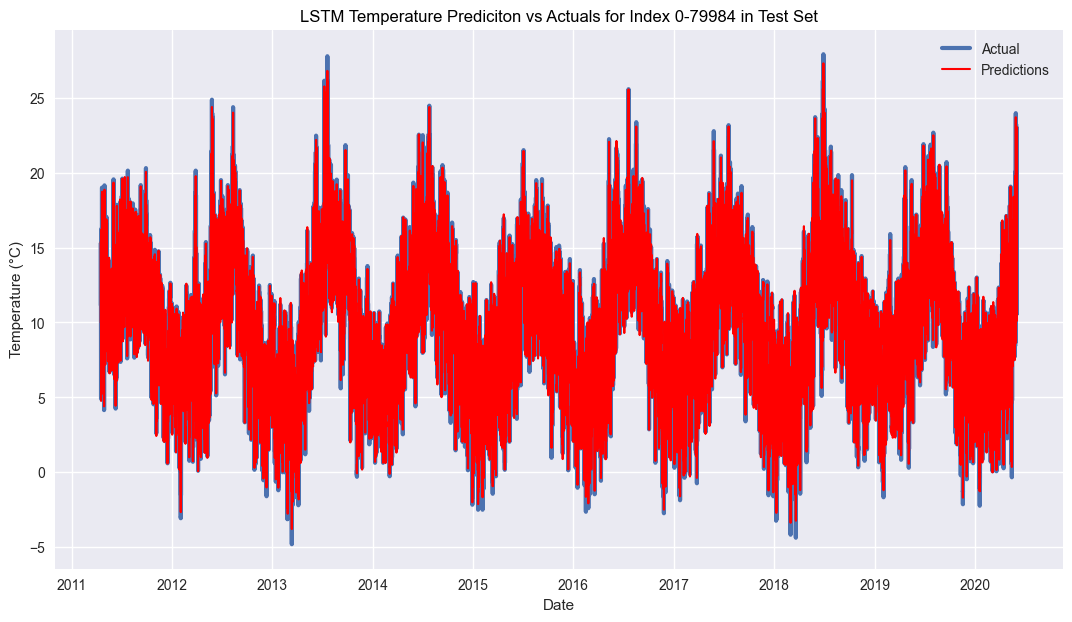

In [253]:
start = 0 # Used for plotting
end = len(lstm_y_test) # Used for plotting

indices_for_plotting = []
for i in range(len(lstm_y_test)):
    indices_for_plotting.append(df.index[-len(gru_y_test) + i])
indices_for_plotting = pd.Series(indices_for_plotting)



plot_predicitons(lstmmodel, lstm_X_test, lstm_y_test, header=lstmmodel.name, start=start, end=end)

Let's take a look at a random sample of 240 hours (10 days) to see how the predicitons did against the actual values at a daily level.

   1/2500 [..............................] - ETA: 1:01

2500/2500 [==============================] - 4s 1ms/step


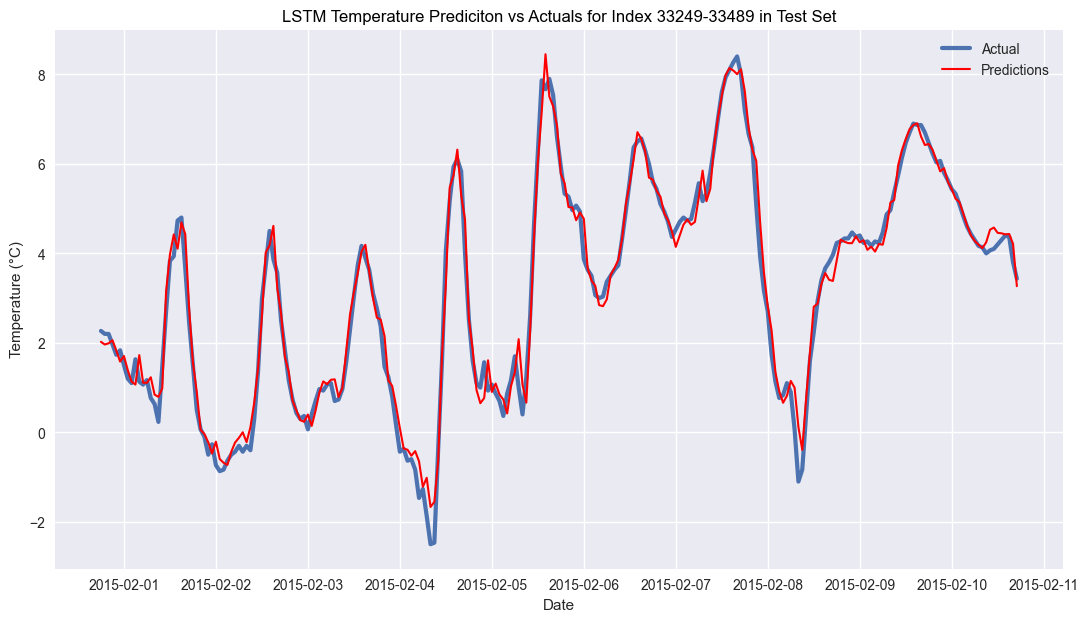

In [254]:
randindex = random.randint(0, len(lstm_y_test)-240)
plot_predicitons(lstmmodel, \
                 lstm_X_test, \
                 lstm_y_test, \
                 header = lstmmodel.name, \
                 start = randindex, \
                 end = randindex + 240)

We see that the predictions did very well against the actual test data! The predictions did a lot better at recognizing local minimum, but at the cost of adding a lot of parameters. The total parameters in the LSTM model are 18449, which is 5056 more parameters than the GRU model. 

The benefit of this model is the metrics, i.e. error, are much lower than the GRU and CNN but at the cost of adding more parameters.

### 9. Compare all models

In this section, I want to compare all the models metrics relatively and also compare the probabilty density function (PDF) of each of the predictions.

Here, I create a table to log all of the metric scores for each of the models. I also sort the models by MAE, so I can see the order in which the models performed.

In [255]:
allmodeldata = [['GRU', grufit.history['mean_absolute_error'][-1],\
                        grufit.history['mean_squared_error'][-1], \
                        grufit.history['root_mean_squared_error'][-1], \
                        13393], \
            ['1D_CNN', cnnfit.history['mean_absolute_error'][-1],\
                        cnnfit.history['mean_squared_error'][-1], \
                        cnnfit.history['root_mean_squared_error'][-1], \
                        2257], \
            ['LSTM', lstmfit.history['mean_absolute_error'][-1],\
                        lstmfit.history['mean_squared_error'][-1], \
                        lstmfit.history['root_mean_squared_error'][-1], \
                        18449],
            ['XGBoost', xgbmae, \
                        xgbmse, \
                        xgbrmse, \
                        pd.NA]]
comparison = pd.DataFrame(allmodeldata, columns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Parameters'])
comparison = comparison.sort_values(by = ['Mean Absolute Error'])
comparison

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Parameters
2,LSTM,0.310582,0.172171,0.414928,18449
0,GRU,0.478282,0.445621,0.667545,13393
1,1D_CNN,0.500215,0.483975,0.695669,2257
3,XGBoost,2.134465,7.533481,2.744719,<NA>


Now that we can see the metric scores for all of the models, this does not give us a look at how the predicitons compared to the actual data throughout the data set. To do this, let's look at the histograms of all the model's predictions.

  60/2500 [..............................] - ETA: 4s

2500/2500 [==============================] - 4s 2ms/step


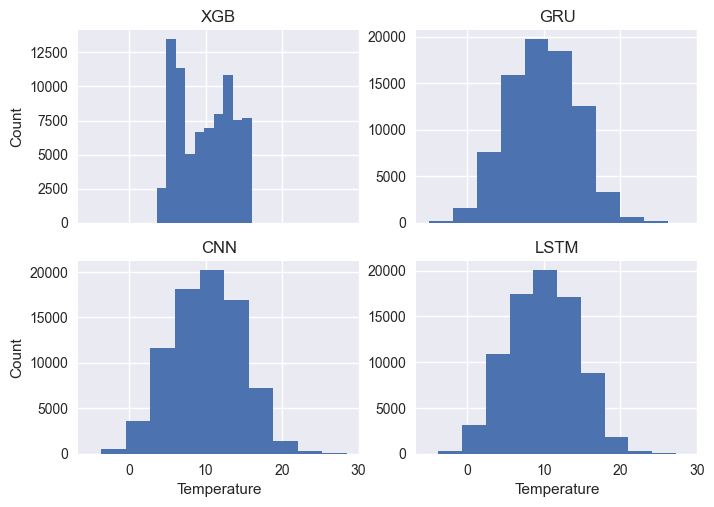

In [256]:
grupreds = grumodel.predict(gru_X_test).flatten()
cnnpreds = cnnmodel.predict(cnn_X_test).flatten()
lstmpreds = lstmmodel.predict(lstm_X_test).flatten()

fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].hist(xgbpreds)
axs[0, 0].set_title('XGB')
axs[0, 1].hist(grupreds)
axs[0, 0].set(ylabel='Count')
axs[0, 1].set_title('GRU')
axs[1, 0].hist(cnnpreds)
axs[1, 0].set_title('CNN')
axs[1, 0].set(xlabel='Temperature')
axs[1, 0].set(ylabel='Count')
axs[1, 1].hist(lstmpreds)
axs[1, 1].set_title('LSTM')
axs[1, 1].set(xlabel='Temperature')
plt.show()

Now that I have the histograms for each model's predictions, let's take a look at the normal curves associated with each histogram.

Let's also graph all of these normals on the same graph.

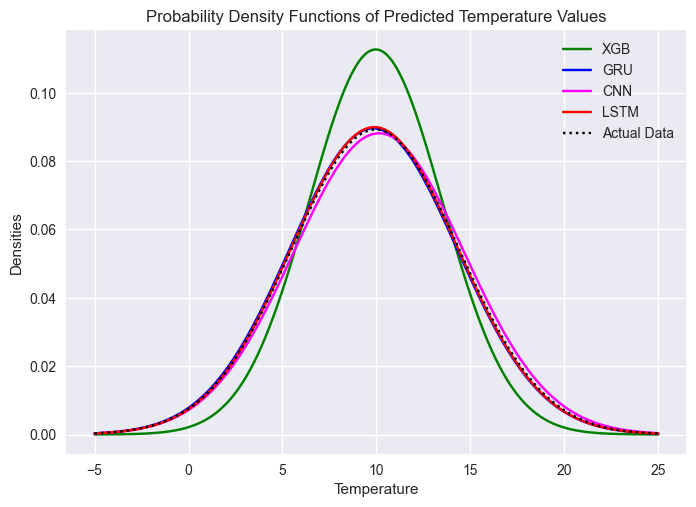

In [257]:
x_axis = np.arange(-5, 25, 0.001)

xgbmean = xgbpreds.mean()
xgbstd = xgbpreds.std()

grumean = grupreds.mean()
grustd = grupreds.std()

cnnmean = cnnpreds.mean()
cnnstd = cnnpreds.std()

lstmmean = lstmpreds.mean()
lstmstd = lstmpreds.std()

actualmean = lstm_y_test.mean()
actualstd = lstm_y_test.std()

plt.style.use('seaborn-v0_8')
plt.plot(x_axis, norm.pdf(x_axis, xgbmean, xgbstd), color='green', label='XGB')
plt.plot(x_axis, norm.pdf(x_axis, grumean, grustd), color='blue', label = 'GRU')
plt.plot(x_axis, norm.pdf(x_axis, cnnmean, cnnstd), color='magenta', label='CNN')
plt.plot(x_axis, norm.pdf(x_axis, lstmmean, lstmstd), color='red', label='LSTM')
plt.plot(x_axis, norm.pdf(x_axis, actualmean, actualstd), ls='dotted', color='black', label='Actual Data')
plt.xlabel('Temperature')
plt.ylabel('Densities')
plt.title(f'Probability Density Functions of Predicted Temperature Values')
plt.legend()
plt.show()

Let's zoom into a x-axis of 1 standard deviation from the actual data's mean and see how our models compare.

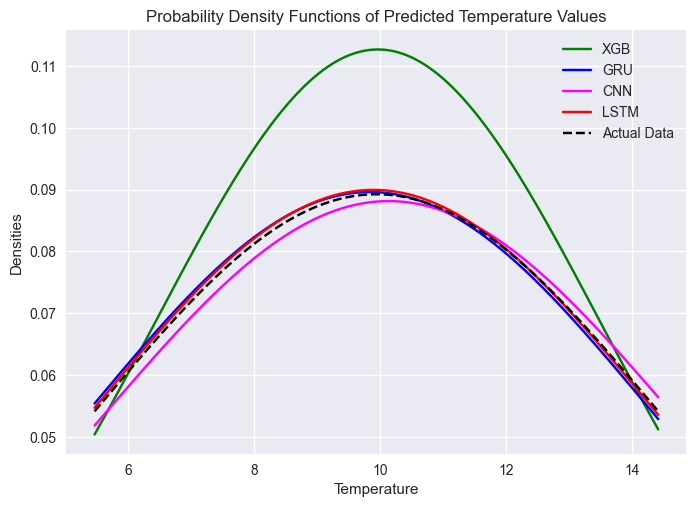

In [258]:
x_axis = np.arange(actualmean - actualstd, actualmean + actualstd, 0.001)

plt.style.use('seaborn-v0_8')
plt.plot(x_axis, norm.pdf(x_axis, xgbmean, xgbstd), color='green', label='XGB')
plt.plot(x_axis, norm.pdf(x_axis, grumean, grustd), color='blue', label = 'GRU')
plt.plot(x_axis, norm.pdf(x_axis, cnnmean, cnnstd), color='magenta', label='CNN')
plt.plot(x_axis, norm.pdf(x_axis, lstmmean, lstmstd), color='red', label='LSTM')
plt.plot(x_axis, norm.pdf(x_axis, actualmean, actualstd), ls='dashed', color='black', label='Actual Data')
plt.xlabel('Temperature')
plt.ylabel('Densities')
plt.title(f'Probability Density Functions of Predicted Temperature Values')
plt.legend()
plt.show()

Obviously further analysis can be done on these distributions and also on the metrics themselves, but a few takeaways can be taken:
- LSTM model performed the best with the lowest MAE, MSE, and RMSE
- GRU and CNN model performed very similarly metric wise, but in terms of parameters, the CNN model had *significantly* less. This would indicate more regularly choosing the CNN model over the GRU because of the low parameters and similar level of output.
- The XGBoost model did not perform to the level of the Keras' Sequential models, but also the XGBoost model did not train on temperature data. So strictly by the calendar features we chose, the XGBoost model learned the general patten of the data (outlined in the XGBoost section of this project)